<a href="https://www.kaggle.com/code/szymnq/regression-with-an-abalone-dataset?scriptVersionId=172652285" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

In [1]:
pip install scikit-lego

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.8/211.8 kB 7.1 MB/s eta 0:00:00
Note: you may need to restart the kernel to use updated packages.


In [2]:
import scipy
import os
import optuna
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.tree import DecisionTreeRegressor, plot_tree
from sklearn.preprocessing import MinMaxScaler, StandardScaler, LabelEncoder, PolynomialFeatures
from sklearn.pipeline import make_pipeline
from sklearn.linear_model import Ridge, RidgeCV, Lasso, LassoCV
from sklearn.model_selection import KFold, StratifiedKFold, train_test_split, GridSearchCV, RepeatedKFold, RepeatedStratifiedKFold, RandomizedSearchCV
from sklearn.metrics import mean_squared_error, mean_absolute_error, mean_squared_log_error
from sklearn.inspection import PartialDependenceDisplay
from sklearn.ensemble import RandomForestRegressor, HistGradientBoostingRegressor, GradientBoostingRegressor, ExtraTreesRegressor
from sklearn.svm import SVR
from lightgbm import LGBMRegressor
from xgboost import XGBRegressor
from catboost import CatBoostRegressor
from sklego.linear_model import LADRegression
from scipy.stats import loguniform

In [3]:
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

/kaggle/input/playground-series-s4e4/sample_submission.csv
/kaggle/input/playground-series-s4e4/train.csv
/kaggle/input/playground-series-s4e4/test.csv


In [4]:
train_df = pd.read_csv('../input/playground-series-s4e4/train.csv')
test_df = pd.read_csv('../input/playground-series-s4e4/test.csv')
combine = [train_df, test_df]

In [5]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 90615 entries, 0 to 90614
Data columns (total 10 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   id              90615 non-null  int64  
 1   Sex             90615 non-null  object 
 2   Length          90615 non-null  float64
 3   Diameter        90615 non-null  float64
 4   Height          90615 non-null  float64
 5   Whole weight    90615 non-null  float64
 6   Whole weight.1  90615 non-null  float64
 7   Whole weight.2  90615 non-null  float64
 8   Shell weight    90615 non-null  float64
 9   Rings           90615 non-null  int64  
dtypes: float64(7), int64(2), object(1)
memory usage: 6.9+ MB


In [6]:
train_df.head()

,id,Sex,Length,Diameter,Height,Whole weight,Whole weight.1,Whole weight.2,Shell weight,Rings
0,0,F,0.550,0.430,0.150,0.7715,0.3285,0.1465,0.2400,11
1,1,F,0.630,0.490,0.145,1.1300,0.4580,0.2765,0.3200,11
2,2,I,0.160,0.110,0.025,0.0210,0.0055,0.0030,0.0050,6
3,3,M,0.595,0.475,0.150,0.9145,0.3755,0.2055,0.2500,10
4,4,I,0.555,0.425,0.130,0.7820,0.3695,0.1600,0.1975,9


In [7]:
train_df.describe()

,id,Length,Diameter,Height,Whole weight,Whole weight.1,Whole weight.2,Shell weight,Rings
count,90615.000000,90615.000000,90615.000000,90615.000000,90615.000000,90615.000000,90615.000000,90615.000000,90615.000000
mean,45307.000000,0.517098,0.401679,0.135464,0.789035,0.340778,0.169422,0.225898,9.696794
std,26158.441658,0.118217,0.098026,0.038008,0.457671,0.204428,0.100909,0.130203,3.176221
min,0.000000,0.075000,0.055000,0.000000,0.002000,0.001000,0.000500,0.001500,1.000000
25%,22653.500000,0.445000,0.345000,0.110000,0.419000,0.177500,0.086500,0.120000,8.000000
50%,45307.000000,0.545000,0.425000,0.140000,0.799500,0.330000,0.166000,0.225000,9.000000
75%,67960.500000,0.600000,0.470000,0.160000,1.067500,0.463000,0.232500,0.305000,11.000000
max,90614.000000,0.815000,0.650000,1.130000,2.825500,1.488000,0.760000,1.005000,29.000000


In [8]:
test_df.head()

,id,Sex,Length,Diameter,Height,Whole weight,Whole weight.1,Whole weight.2,Shell weight
0,90615,M,0.645,0.475,0.155,1.2380,0.6185,0.3125,0.3005
1,90616,M,0.580,0.460,0.160,0.9830,0.4785,0.2195,0.2750
2,90617,M,0.560,0.420,0.140,0.8395,0.3525,0.1845,0.2405
3,90618,M,0.570,0.490,0.145,0.8740,0.3525,0.1865,0.2350
4,90619,I,0.415,0.325,0.110,0.3580,0.1575,0.0670,0.1050


Preprocessing

In [9]:
# Outliers
def outlier_thresholds(df, var, q1=0.05, q3=0.95):
    q1 = df[var].quantile(q1)
    q3 = df[var].quantile(q3)
    iqr = q3 - q1
    lower_limit = q1 - 1.5 * iqr
    upper_limit = q3 + 1.5 * iqr
    
    return lower_limit, upper_limit

In [10]:
numeric_columns = train_df.select_dtypes(include='number').columns.tolist()
numeric_columns.remove('id')
numeric_columns.remove('Rings')

for i in numeric_columns:
    print(i, ":", outlier_thresholds(train_df, i))

Length : (-0.32000000000000006, 1.2800000000000002)
Diameter : (-0.2775000000000001, 1.0225000000000002)
Height : (-0.1175, 0.3825)
Whole weight : (-2.1590000000000003, 3.8850000000000002)
Whole weight.1 : (-0.9582499999999999, 1.7117499999999999)
Whole weight.2 : (-0.4757499999999999, 0.85425)
Shell weight : (-0.6125, 1.1035000000000001)


In [11]:
outlier_indexes = []

def check_outliers(df, var):
    lower_limit, upper_limit = outlier_thresholds(df, var)

    if df[(df[var] < lower_limit) | (df[var] > upper_limit)].shape[0] > 0:
        print(var, "-->",
              df[(df[var] < lower_limit) | (df[var] > upper_limit)].shape[0])
        outlier_indexes.append(
            df[(df[var] < lower_limit) | (df[var] > upper_limit)].index)
        return True
    else:
        return False

for i in numeric_columns:
    print(i, ":", check_outliers(train_df, i))
print("Indexes-->", outlier_indexes)

Length : False
Diameter : False
Height --> 8
Height : True
Whole weight : False
Whole weight.1 : False
Whole weight.2 : False
Shell weight : False
Indexes--> [Index([16384, 28651, 55852, 56089, 58048, 63851, 65464, 77326], dtype='int64')]


In [12]:
def remove_outliers(df, var):
    lower_limit, upper_limit = outlier_thresholds(df, var)
    print(df[(df[var] < lower_limit) | (df[var] > upper_limit)])
    df = df[~((df[var] < lower_limit) | (df[var] > upper_limit))]
    return df

print(train_df.shape)
train_df = remove_outliers(train_df, "Height")
print(train_df.shape)

(90615, 10)
          id Sex  Length  Diameter  Height  Whole weight  Whole weight.1  \
16384  16384   F   0.515     0.375   1.130        0.5720          0.2370   
28651  28651   F   0.665     0.515   0.500        1.7825          0.5330   
55852  55852   M   0.745     0.545   0.500        1.7875          0.8075   
56089  56089   F   0.705     0.575   0.515        2.2100          1.1075   
58048  58048   F   0.635     0.495   0.500        1.2615          0.5385   
63851  63851   M   0.640     0.510   0.500        1.3715          0.5065   
65464  65464   M   0.585     0.450   1.130        1.1000          0.5085   
77326  77326   F   0.565     0.455   1.000        1.0145          0.5255   

       Whole weight.2  Shell weight  Rings  
16384          0.1455        0.1500      8  
28651          0.3340        0.4285     10  
55852          0.3935        0.5650     10  
56089          0.4865        0.5120     11  
58048          0.3050        0.3750     11  
63851          0.3050        0.47

In [13]:
#OneHotEncoding
le = LabelEncoder()

for dataset in combine:
    dataset['Sex'] = le.fit_transform(dataset['Sex'])
    dataset.columns = dataset.columns.str.replace(' ', '_')

In [14]:
train_df, test_df = combine[0], combine[1]

In [15]:
train_df.head()

,id,Sex,Length,Diameter,Height,Whole_weight,Whole_weight.1,Whole_weight.2,Shell_weight,Rings
0,0,0,0.550,0.430,0.150,0.7715,0.3285,0.1465,0.2400,11
1,1,0,0.630,0.490,0.145,1.1300,0.4580,0.2765,0.3200,11
2,2,1,0.160,0.110,0.025,0.0210,0.0055,0.0030,0.0050,6
3,3,2,0.595,0.475,0.150,0.9145,0.3755,0.2055,0.2500,10
4,4,1,0.555,0.425,0.130,0.7820,0.3695,0.1600,0.1975,9


In [16]:
test_df.head()

,id,Sex,Length,Diameter,Height,Whole_weight,Whole_weight.1,Whole_weight.2,Shell_weight
0,90615,2,0.645,0.475,0.155,1.2380,0.6185,0.3125,0.3005
1,90616,2,0.580,0.460,0.160,0.9830,0.4785,0.2195,0.2750
2,90617,2,0.560,0.420,0.140,0.8395,0.3525,0.1845,0.2405
3,90618,2,0.570,0.490,0.145,0.8740,0.3525,0.1865,0.2350
4,90619,1,0.415,0.325,0.110,0.3580,0.1575,0.0670,0.1050


Base model

In [17]:
def rmsle(predictions, targets):
    """Calculate the root mean squared logarithmic error between predictions and targets"""
    return np.sqrt(np.mean((np.log(predictions + 1) - np.log(targets + 1)) ** 2))

In [18]:
X = train_df.drop(columns = ['id', 'Rings'], axis = 1)
y = train_df['Rings']

gb_cv_scores, gb_preds = list(), list()
hist_cv_scores, hist_preds = list(), list()
lgb_cv_scores, lgb_preds = list(), list()
xgb_cv_scores, xgb_preds = list(), list()
ens_cv_scores, ens_preds = list(), list()

skf = KFold(n_splits = 10, random_state = 42, shuffle = True)

In [19]:
X.head()

,Sex,Length,Diameter,Height,Whole_weight,Whole_weight.1,Whole_weight.2,Shell_weight
0,0,0.550,0.430,0.150,0.7715,0.3285,0.1465,0.2400
1,0,0.630,0.490,0.145,1.1300,0.4580,0.2765,0.3200
2,1,0.160,0.110,0.025,0.0210,0.0055,0.0030,0.0050
3,2,0.595,0.475,0.150,0.9145,0.3755,0.2055,0.2500
4,1,0.555,0.425,0.130,0.7820,0.3695,0.1600,0.1975


In [20]:
for i, (train_i, test_i) in enumerate(skf.split(X, y)):
    X_train, X_test = X.iloc[train_i], X.iloc[test_i]
    y_train, y_test = y.iloc[train_i], y.iloc[test_i]
    
    print('-------------------------------------------')
    # GradientBoosting
    gb_md = GradientBoostingRegressor().fit(X_train, y_train)
    
    gb_pred = gb_md.predict(X_test)
    gb_score = rmsle(gb_pred, y_test)
    
    gb_preds.append(gb_pred)
    gb_cv_scores.append(gb_score)
    
    print(f'Fold {i} => GradientBoosting of MAE =>', gb_score)
    
    # HistGradientBoosting
    hist_md = HistGradientBoostingRegressor().fit(X_train, y_train)
                                       
    hist_pred = hist_md.predict(X_test)
    hist_score = rmsle(hist_pred, y_test)
    
    hist_preds.append(hist_pred)
    hist_cv_scores.append(hist_score)
    
    print(f'Fold {i} => HistGradientBoosting of RMSLE =>', hist_score)
    
    # LightGBM
    lgb_md = LGBMRegressor().fit(X_train, y_train)
                                       
    lgb_pred = lgb_md.predict(X_test)
    lgb_score = rmsle(lgb_pred, y_test)
    
    lgb_preds.append(lgb_pred)
    lgb_cv_scores.append(lgb_score)
    
    print(f'Fold {i} => LightGBM of RMSLE =>', lgb_score)
    
    # XGBoost
    xgb_md = XGBRegressor().fit(X_train, y_train)
                                       
    xgb_pred = hist_md.predict(X_test)
    xgb_score = rmsle(xgb_pred, y_test)
    
    xgb_preds.append(xgb_pred)
    xgb_cv_scores.append(xgb_score)
    
    print(f'Fold {i} => XGBoost of RMSLE =>', xgb_score)
    
    # LAD Ensemble
    ens_md = LADRegression().fit(X_train, y_train)
                                       
    ens_pred = ens_md.predict(X_test)
    ens_score = rmsle(ens_pred, y_test)
    
    ens_preds.append(ens_pred)
    ens_cv_scores.append(ens_score)
    
    print(f'Fold {i} => Ensemble of RMSLE =>', ens_score)

-------------------------------------------
Fold 0 => GradientBoosting of MAE => 0.15400905902866383
Fold 0 => HistGradientBoosting of RMSLE => 0.1510077017300647
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.018920 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1332
[LightGBM] [Info] Number of data points in the train set: 81553, number of used features: 8
[LightGBM] [Info] Start training from score 9.700845
Fold 0 => LightGBM of RMSLE => 0.1507498625987879
Fold 0 => XGBoost of RMSLE => 0.1510077017300647
Fold 0 => Ensemble of RMSLE => 0.16490478680648013
-------------------------------------------
Fold 1 => GradientBoosting of MAE => 0.15696410878044767
Fold 1 => HistGradientBoosting of RMSLE => 0.15460816253425677
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.016547 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] To

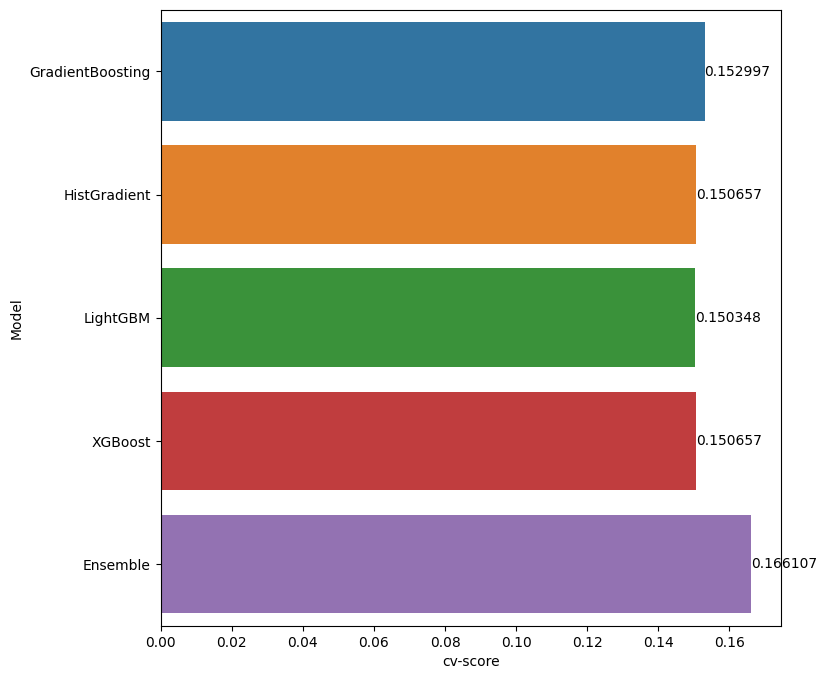

In [21]:
gb_cv_score = np.mean(gb_cv_scores)
hist_cv_score = np.mean(hist_cv_scores)
lgb_cv_score = np.mean(lgb_cv_scores)
xgb_cv_score = np.mean(xgb_cv_scores)
ens_cv_score = np.mean(ens_cv_scores)

model_perf = pd.DataFrame({'Model': ['GradientBoosting', 'HistGradient' ,'LightGBM', 'XGBoost', 'Ensemble'],
                           'cv-score': [gb_cv_score, hist_cv_score, lgb_cv_score, xgb_cv_score, ens_cv_score]})

plt.figure(figsize = (8, 8))
ax = sns.barplot(y = 'Model', x = 'cv-score', data = model_perf)
ax.bar_label(ax.containers[0]);

Hyperparameter tuning

In [22]:
# LightGBM hyper-parameters tuning
def objective(trial):
    X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.3, random_state=42) 
    
    params = {
        "objective": "regression",
        "metric": "rmse",
        "n_estimators": 1000,
        "verbosity": -1,
        "bagging_freq": 1,
        "learning_rate": trial.suggest_float("learning_rate", 1e-3, 0.1, log=True),
        "num_leaves": trial.suggest_int("num_leaves", 2, 2**10),
        "subsample": trial.suggest_float("subsample", 0.05, 1.0),
        "colsample_bytree": trial.suggest_float("colsample_bytree", 0.05, 1.0),
        "min_data_in_leaf": trial.suggest_int("min_data_in_leaf", 1, 100),
        "verbose": -1,
        "force_col_wise": True,
    }
    

    model = LGBMRegressor(**params)
    model.fit(X_train, y_train)
    predictions = model.predict(X_val)
    result = rmsle(predictions, y_val)
    return result

In [23]:
# study = optuna.create_study(direction='minimize')
# study.optimize(objective, n_trials=30)

In [24]:
# print('Best hyperparameters:', study.best_params)
# print('Best RMSLE:', study.best_value)

#### Best params:
{'learning_rate': 0.005547686883024982, 'num_leaves': 380, 'subsample': 0.6082114295688092, 'colsample_bytree': 0.682765023104069, 'min_data_in_leaf': 26}


In [25]:
lgbmr_clf = LGBMRegressor(learning_rate = 0.005547686883024982,
                          num_leaves = 380,
                          subsample = 0.6082114295688092,
                          colsample_bytree = 0.682765023104069,
                          min_data_in_leaf = 26,
                         )

In [26]:
#XGBoost hyper-parameters tuning
def hyperParameterTuning(X_train, y_train):
    param_tuning = {
        'learning_rate': [0.01, 0.1],
        'max_depth': [3, 5, 7, 10],
        'min_child_weight': [1, 3, 5],
        'subsample': [0.5, 0.7],
        'colsample_bytree': [0.5, 0.7],
        'n_estimators' : [100, 200, 500],
        'objective': ['reg:squarederror']
    }

    xgb_model = XGBRegressor()

    gsearch = GridSearchCV(estimator = xgb_model,
                           param_grid = param_tuning,                        
                           scoring = 'neg_mean_squared_error',
                           cv = 5,
                           n_jobs = -1,
                           verbose = 1)

    gsearch.fit(X_train,y_train)

    return gsearch.best_params_

In [27]:
# hyperParameterTuning(X, y)

#### Best Params
{'colsample_bytree': 0.7,
 'learning_rate': 0.01,
 'max_depth': 10,
 'min_child_weight': 5,
 'n_estimators': 500,
 'objective': 'reg:squarederror',
 'subsample': 0.7}

In [28]:
# xgb_clf = XGBRegressor(objective = 'reg:squarederror',
#                        colsample_bytree = 0.7,
#                        learning_rate = 0.01,
#                        max_depth = 10,
#                        min_child_weight = 5,
#                        n_estimators = 500,
#                        subsample = 0.7)

In [29]:
lgbmr_clf.fit(train_df.loc[:, ~(train_df.columns.isin(['Rings', 'id']))], train_df.loc[:, 'Rings'])
predictions = pd.Series(lgbmr_clf.predict(test_df.iloc[:, 1:]), name="Rings")

[LightGBM] [Warning] min_data_in_leaf is set=26, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=26
[LightGBM] [Warning] min_data_in_leaf is set=26, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=26
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.018287 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1334
[LightGBM] [Info] Number of data points in the train set: 90615, number of used features: 8
[LightGBM] [Info] Start training from score 9.696794
[LightGBM] [Warning] min_data_in_leaf is set=26, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=26


In [30]:
results = pd.concat([test_df["id"][:len(predictions)], predictions], axis=1)
results.to_csv("/kaggle/working/result.csv", index=False)